# Search for the Next Food Concept
### A Capstone Project for Coursera Data Science Course
By: Hermie Dalay

The objective of this project is to learn what food concept is prevalent and understand the trend in the food business in Metro Manila cities. It is also the objective of this project to see the locations where most food businesses are concentrated. Exploring the existing businesses in the city centers of Metro Manila, we may be able to get insights that may help us in our decision to start a new food business.
By the end of this project, we may be able to know the existing trend in food business in Metro Manila and the ideal locations for it.


# 1. Importing and installing libraries

In [1]:
#importing, install libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                       

# 2. Data extraction and cleaning

## 2.1 Reading and cleaning of city locations data

In [2]:
# The code was removed by Watson Studio for sharing.

,Place Name,Latitude,Longitude
0,"Maasin City, Southern Leyte, Philippinnes",10.13140,124.85848
1,"Cagayan de Oro, Misamis Oriental, Philippines",8.47722,124.64592
2,"Silay City, Negros Occidental, Philippines",10.75379,123.08416
3,"Taytay, Rizal, Philippines",14.55856,121.13609
4,"Bago City, Negros Occidental, Philippines",10.50341,122.96630


In [3]:
# Since I already have the locations in csv file, the data can be easily cleaned in excel 
# but I want to practice the cleaning and extracting process thru coding. I can use these codes for future projects.

# convert to dataframe
cities_df = pd.DataFrame(df_data_1, columns = ['Place Name', 'Latitude', 'Longitude'])
#cities_df.head()

# change column name
cities_df.rename(columns={'Place Name': 'City'}, inplace=True)
#cities_df.tail(10)

#extract metro manila cities only
manila_data = cities_df[cities_df['City'].str.contains('Metro Manila')]
manila_data.reset_index(inplace=True, drop=True)
#manila_data.head(20)

# simplify city names
manila_data['City'] = manila_data['City'].str.replace(', Metro Manila, Philippines','')

#manila_data['Neighborhood'].loc[manila_data['Neighborhood'] == 'Metro Manila, Philippines'].replace("", inplace=True, regex=True)
manila_data.head(20)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,City,Latitude,Longitude
0,Pasay,14.53775,121.00138
1,Muntinlupa,14.40813,121.04147
2,Valenzuela,14.70358,120.98654
3,Manila,14.59951,120.98422
4,Makati,14.55659,121.02342
5,Taguig City,14.52045,121.05389
6,Quezon City,14.67621,121.04386
7,Caloocan City,14.64953,120.96788
8,Las Pinas City,14.45056,120.98278
9,Malabon City,14.66810,120.96580


## 2.2 Get and explore venues from foursquare

In [4]:
#Initialize Foursquare credentials

CLIENT_ID = 'V253AN4OKKK034FDX0GI0YGBLP0MQTA3NYZC3QIWLRC0NOMV' # your Foursquare ID
CLIENT_SECRET = 'PJBZTIK5XIH2OJDBCMCEG1Q55YG0SNZE05WZVHGHL3MWLUUX' # your Foursquare Secret
VERSION = '20200611' # Foursquare API version 20180605

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## 2.2 Extraction and cleaning of cities location

Your credentails:
CLIENT_ID: V253AN4OKKK034FDX0GI0YGBLP0MQTA3NYZC3QIWLRC0NOMV
CLIENT_SECRET:PJBZTIK5XIH2OJDBCMCEG1Q55YG0SNZE05WZVHGHL3MWLUUX


In [5]:
# define function to extract venues, under main category food, within 3km radius of city centers using Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=500, categoryId='4d4b7105d754a06374d81259'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
   #         v['venue']['location']['city'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'] [0]['name']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City',
            'City Latitude',
            'City Longitude',
            'Venue',
    #        'Venue City',
            'Venue Latitude',
            'Venue Longitude',
            'Venue Category']
    
    return(nearby_venues)

In [22]:
# extract venues, call function getNearbyVenues, of each city
manila_venues = getNearbyVenues(names=manila_data['City'],
                                   latitudes=manila_data['Latitude'],
                                   longitudes=manila_data['Longitude']
                                  )

Pasay
Muntinlupa
Valenzuela
Manila
Makati
Taguig City
Quezon City
Caloocan City
Las Pinas City
Malabon City
Mandaluyong City
Marikina City
Navotas City
Paranaque City
Pasig City
San Juan City


In [23]:
#check data format
print(manila_venues.shape)
manila_venues.head()

(1517, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pasay,14.53775,121.00138,S&R Food Counter,14.529792,120.991295,Fast Food Restaurant
1,Pasay,14.53775,121.00138,Conrad's Grille,14.526522,120.999771,BBQ Joint
2,Pasay,14.53775,121.00138,Yabu: House of Katsu,14.536158,120.981613,Japanese Restaurant
3,Pasay,14.53775,121.00138,Izakaya Kikufuji,14.553680,121.013838,Japanese Restaurant
4,Pasay,14.53775,121.00138,House of Wagyu Stone Grill,14.539491,120.980891,Australian Restaurant


In [24]:
# count venues for each city
manila_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Caloocan City,100,100,100,100,100,100
Las Pinas City,100,100,100,100,100,100
Makati,100,100,100,100,100,100
Malabon City,98,98,98,98,98,98
Mandaluyong City,100,100,100,100,100,100
Manila,100,100,100,100,100,100
Marikina City,100,100,100,100,100,100
Muntinlupa,100,100,100,100,100,100
Navotas City,63,63,63,63,63,63


In [25]:
# check out the food categories
Categories = manila_venues['Venue Category'].unique()
print('There are {} uniques categories.'.format(len(manila_venues['Venue Category'].unique())))
print(manila_venues['Venue Category'].unique())

There are 75 uniques categories.
['Fast Food Restaurant' 'BBQ Joint' 'Japanese Restaurant'
 'Australian Restaurant' 'Pizza Place' 'Steakhouse' 'Bakery' 'Café'
 'American Restaurant' 'French Restaurant' 'Salad Place'
 'Tex-Mex Restaurant' 'Seafood Restaurant' 'Filipino Restaurant'
 'Asian Restaurant' 'Snack Place' 'Vietnamese Restaurant' 'Buffet'
 'Greek Restaurant' 'Burger Joint' 'Noodle House' 'Ramen Restaurant'
 'Thai Restaurant' 'Theme Restaurant' 'Chinese Restaurant' 'Deli / Bodega'
 'Tonkatsu Restaurant' 'Dim Sum Restaurant' 'Creperie'
 'Caribbean Restaurant' 'Swiss Restaurant' 'Mediterranean Restaurant'
 'Burrito Place' 'Korean Restaurant' 'Restaurant' 'Italian Restaurant'
 'Sandwich Place' 'Udon Restaurant' 'Donut Shop' 'Indian Restaurant'
 'Bistro' 'Modern European Restaurant' 'Diner' 'Spanish Restaurant'
 'Gastropub' 'Mexican Restaurant' 'Sushi Restaurant' 'Wings Joint'
 'Food Court' 'Hot Dog Joint' 'South American Restaurant'
 'Comfort Food Restaurant' 'Fried Chicken Joint' '

## 2.3 Plot extracted venues in the map for visualization

In [26]:
# set map longitude, latitude to Manila center
latitude = 14.6091
longitude = 121.0223
map_foods = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
#colors = rainbow

for lat1, lon1 in zip(manila_data['Latitude'], manila_data['Longitude']):
    folium.Circle(location=[lat1, lon1], popup='Point 1A', fill_color='#000', radius=3000, weight=2, color="#000").add_to(map_foods)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manila_venues['Venue Latitude'], manila_venues['Venue Longitude'], manila_venues['City'], manila_venues['Venue']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_foods)
       
map_foods

## 3.0 Data Analysis and Exploration

## 3.1 One hot encoding

In [27]:
# one hot encoding by venue category
manila_onehot = pd.get_dummies(manila_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manila_onehot['City'] = manila_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [manila_onehot.columns[-1]] + list(manila_onehot.columns[:-1])
manila_onehot = manila_onehot[fixed_columns]

manila_onehot.head()

,City,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Noodle House,North Indian Restaurant,Persian Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Snack Place,Soup Place,South American Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Pasay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Pasay,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pasay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Pasay,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Pasay,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# check the shape of the dataframe
manila_onehot.shape

(1517, 76)

In [37]:
# group by 'City', sum frequency for each category

manila_grouped = manila_onehot.groupby('City').sum(axis=0).reset_index()

manila_grouped.columns

Index(['City', 'American Restaurant', 'Asian Restaurant',
       'Australian Restaurant', 'BBQ Joint', 'Bakery', 'Bistro',
       'Breakfast Spot', 'Buffet', 'Burger Joint', 'Burrito Place',
       'Cafeteria', 'Café', 'Cantonese Restaurant', 'Caribbean Restaurant',
       'Chinese Restaurant', 'Comfort Food Restaurant', 'Creperie',
       'Deli / Bodega', 'Dim Sum Restaurant', 'Diner', 'Donut Shop',
       'Dumpling Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant',
       'Filipino Restaurant', 'Food', 'Food Court', 'Food Stand', 'Food Truck',
       'French Restaurant', 'Fried Chicken Joint', 'Gastropub',
       'German Restaurant', 'Greek Restaurant', 'Hot Dog Joint',
       'Indian Restaurant', 'Italian Restaurant', 'Japanese Curry Restaurant',
       'Japanese Restaurant', 'Kebab Restaurant', 'Korean Restaurant',
       'Latin American Restaurant', 'Malay Restaurant',
       'Mediterranean Restaurant', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'Modern Euro

In [38]:
# Combine all japanese themed restaurant to Japanese Restaurant
manila_grouped['Japanese Restaurants'] = manila_grouped['Japanese Curry Restaurant'] + manila_grouped['Japanese Restaurant']\
    + manila_grouped['Ramen Restaurant'] + manila_grouped['Sushi Restaurant'] + manila_grouped['Tonkatsu Restaurant']\
    + manila_grouped['Udon Restaurant'] + manila_grouped['Shabu-Shabu Restaurant']

# Drop combined columns    
manila_grouped.drop(['Japanese Restaurant', 'Japanese Curry Restaurant', 'Ramen Restaurant', 'Sushi Restaurant', 'Tonkatsu Restaurant',
                     'Udon Restaurant', 'Shabu-Shabu Restaurant'], axis = 1, inplace=True)

# Combine all Mexican themed restaurant to All Mexican Restaurant
manila_grouped['Latino Restaurants'] = manila_grouped['Burrito Place'] + manila_grouped['Latin American Restaurant']\
    + manila_grouped['Mexican Restaurant'] + manila_grouped['South American Restaurant'] + manila_grouped['Taco Place']\
    + manila_grouped['Tapas Restaurant'] + manila_grouped['Tex-Mex Restaurant']

# Drop combined columns    
manila_grouped.drop(['Burrito Place', 'Latin American Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Taco Place',
                     'Tapas Restaurant', 'Tex-Mex Restaurant'], axis = 1, inplace=True)

# Combine all Chinese themed restaurant to All Chinese Restaurant
manila_grouped['Chinese Restaurants'] = manila_grouped['Cantonese Restaurant'] + manila_grouped['Chinese Restaurant']\
    + manila_grouped['Dim Sum Restaurant'] + manila_grouped['Dumpling Restaurant'] + manila_grouped['Noodle House']

# Drop combined columns    
manila_grouped.drop(['Cantonese Restaurant', 'Chinese Restaurant', 'Dim Sum Restaurant', 'Dumpling Restaurant', 'Noodle House'], 
                    axis = 1, inplace=True)

# Combine all Mediterranean and Middle East themed restaurant to All ME Mediterranean Restaurant
manila_grouped['Arab_Medi Restaurants'] = manila_grouped['Falafel Restaurant'] + manila_grouped['Kebab Restaurant']\
    + manila_grouped['Mediterranean Restaurant'] + manila_grouped['Middle Eastern Restaurant'] + manila_grouped['Persian Restaurant']

# Drop combined columns    
manila_grouped.drop(['Falafel Restaurant', 'Kebab Restaurant', 'Mediterranean Restaurant', 'Middle Eastern Restaurant', 'Persian Restaurant'], 
                    axis = 1, inplace=True)

# Combine all Cafeteria themed restaurant to All Cafeteria Restaurant
manila_grouped['Coffee Shops'] = manila_grouped['Breakfast Spot'] + manila_grouped['Cafeteria'] + manila_grouped['Café']

# Drop combined columns    
manila_grouped.drop(['Breakfast Spot', 'Cafeteria', 'Café'], axis = 1, inplace=True)

# Combine all Spanish themed restaurant to All Spanish Restaurant
#manila_grouped['All Spanish Restaurant'] = manila_grouped['Paella Restaurant'] + manila_grouped['Spanish Restaurant']

# Drop combined columns    
#manila_grouped.drop(['Paella Restaurant', 'Spanish Restaurant'], axis = 1, inplace=True)

# Combine all Indian themed restaurant to All Indian Restaurant
manila_grouped['Indian Restaurants'] = manila_grouped['Indian Restaurant'] + manila_grouped['North Indian Restaurant']

# Drop combined columns    
manila_grouped.drop(['Indian Restaurant', 'North Indian Restaurant'], axis = 1, inplace=True)

# Combine all Fast food type restaurant to All Fast Food Restaurant
manila_grouped['Fast Food Restaurants'] = manila_grouped['BBQ Joint'] + manila_grouped['Burger Joint'] + manila_grouped['Fast Food Restaurant']\
    + manila_grouped['Hot Dog Joint'] + manila_grouped['Fried Chicken Joint'] + manila_grouped['Snack Place'] + manila_grouped['Soup Place']\
    + manila_grouped['Wings Joint'] + manila_grouped['Salad Place'] + manila_grouped['Sandwich Place']

# Drop combined columns    
manila_grouped.drop(['BBQ Joint', 'Burger Joint', 'Fast Food Restaurant', 'Hot Dog Joint', 'Fried Chicken Joint', 'Snack Place', 'Soup Place',
                     'Salad Place', 'Sandwich Place', 'Wings Joint'], axis = 1, inplace=True)

# Combine all American themed restaurant to All American Restaurant
manila_grouped['American Restaurants'] = manila_grouped['American Restaurant'] + manila_grouped['Diner'] + manila_grouped['Steakhouse']

# Drop combined columns    
manila_grouped.drop(['American Restaurant', 'Diner', 'Steakhouse'], axis = 1, inplace=True)

# Combine all Bar themed restaurant to All Bar
manila_grouped['Bars and Bistros'] = manila_grouped['Bistro'] + manila_grouped['Gastropub']

# Drop combined columns    
manila_grouped.drop(['Bistro', 'Gastropub'], axis = 1, inplace=True)

# Drop all uncategorized    
manila_grouped.drop(['Food', 'Food Stand', 'Food Truck', 'Food Court'], axis = 1, inplace=True)

# Combine all Sweets & Comfort Food shops to Sweets Shops
manila_grouped['Sweet Shops'] = manila_grouped['Comfort Food Restaurant'] + manila_grouped['Creperie'] + manila_grouped['Deli / Bodega']

# Drop combined columns    
manila_grouped.drop(['Comfort Food Restaurant', 'Creperie', 'Deli / Bodega'], axis = 1, inplace=True)



In [39]:

New_Category_Total = [manila_grouped.sum(axis=0)]
#New_Category_Total = New_Category_Total.sort()
df_Category_Total = pd.DataFrame (New_Category_Total)
df_Category_Total.drop(['City'], axis = 1, inplace=True)
df_Transpose = df_Category_Total.transpose()
df_Transpose = df_Transpose.reset_index()

df_Transpose.rename(columns={'index': "Category", 0: "Total"}, inplace=True)
df_Transpose.sort_values(by='Total', ascending= False, inplace=True)
df_Transpose

,Category,Total
30,Fast Food Restaurants,258
26,Chinese Restaurants,153
28,Coffee Shops,151
24,Japanese Restaurants,136
6,Filipino Restaurant,126
31,American Restaurants,83
15,Pizza Place,82
2,Bakery,61
25,Latino Restaurants,59
0,Asian Restaurant,49


In [40]:
Top_20_Restaurants = df_Transpose.head(20)
print(Top_20_Restaurants)

                 Category  Total
30  Fast Food Restaurants    258
26    Chinese Restaurants    153
28           Coffee Shops    151
24   Japanese Restaurants    136
6     Filipino Restaurant    126
31   American Restaurants     83
15            Pizza Place     82
2                  Bakery     61
25     Latino Restaurants     59
0        Asian Restaurant     49
16             Restaurant     43
10     Italian Restaurant     41
11      Korean Restaurant     33
5              Donut Shop     30
33            Sweet Shops     28
27  Arab_Medi Restaurants     24
3                  Buffet     20
23  Vietnamese Restaurant     13
18     Spanish Restaurant     12
20        Thai Restaurant     12


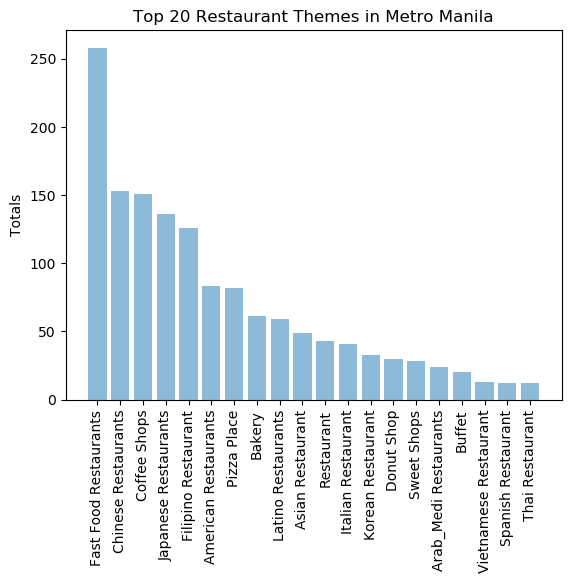

In [42]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

objects = (Top_20_Restaurants['Category'])
y_pos = np.arange(len(objects))
performance = [10,8,6,4,2,1]

plt.bar(y_pos, Top_20_Restaurants['Total'], align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Totals')
plt.title('Top 20 Restaurant Themes in Metro Manila')

plt.show()

In [43]:
# check top 10 venues for each city
num_top_venues = 10
# note: changed 'freq' with 'count'
for hood in manila_grouped['City']:
    print("----"+hood+"----")
    temp = manila_grouped[manila_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','count']
    temp = temp.iloc[1:]
    temp['count'] = temp['count'].astype(float)
    temp = temp.round({'count': 2})
    print(temp.sort_values('count', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Caloocan City----
                   venue  count
0    Chinese Restaurants   23.0
1  Fast Food Restaurants   19.0
2    Filipino Restaurant   10.0
3           Coffee Shops    8.0
4       Asian Restaurant    7.0
5            Pizza Place    7.0
6                 Bakery    4.0
7   American Restaurants    4.0
8   Japanese Restaurants    3.0
9             Donut Shop    2.0


----Las Pinas City----
                   venue  count
0  Fast Food Restaurants   28.0
1    Filipino Restaurant   10.0
2           Coffee Shops    9.0
3   Japanese Restaurants    9.0
4            Pizza Place    8.0
5      Korean Restaurant    4.0
6    Chinese Restaurants    4.0
7             Restaurant    4.0
8   American Restaurants    4.0
9             Donut Shop    3.0


----Makati----
                   venue  count
0   Japanese Restaurants   13.0
1           Coffee Shops   11.0
2    Filipino Restaurant   10.0
3  Fast Food Restaurants    9.0
4                 Bakery    6.0
5      Korean Restaurant    5.0
6       

In [44]:
# function to get the most common
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manila_venues_sorted = pd.DataFrame(columns=columns)
manila_venues_sorted['City'] = manila_grouped['City']

for ind in np.arange(manila_grouped.shape[0]):
    manila_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manila_grouped.iloc[ind, :], num_top_venues)

manila_venues_sorted.head(16)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Caloocan City,Chinese Restaurants,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Asian Restaurant,Pizza Place,American Restaurants,Bakery,Japanese Restaurants,Donut Shop
1,Las Pinas City,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Japanese Restaurants,Pizza Place,Restaurant,American Restaurants,Chinese Restaurants,Korean Restaurant,Bakery
2,Makati,Japanese Restaurants,Coffee Shops,Filipino Restaurant,Fast Food Restaurants,Bakery,Restaurant,Korean Restaurant,Arab_Medi Restaurants,Chinese Restaurants,Latino Restaurants
3,Malabon City,Fast Food Restaurants,Chinese Restaurants,Asian Restaurant,American Restaurants,Coffee Shops,Filipino Restaurant,Donut Shop,Pizza Place,Japanese Restaurants,Restaurant
4,Mandaluyong City,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Latino Restaurants,Chinese Restaurants,Filipino Restaurant,Pizza Place,American Restaurants,Arab_Medi Restaurants,Korean Restaurant
5,Manila,Chinese Restaurants,Filipino Restaurant,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Pizza Place,Bakery,American Restaurants,Asian Restaurant,Arab_Medi Restaurants
6,Marikina City,Coffee Shops,Fast Food Restaurants,American Restaurants,Filipino Restaurant,Japanese Restaurants,Pizza Place,Chinese Restaurants,Latino Restaurants,Bakery,Italian Restaurant
7,Muntinlupa,Fast Food Restaurants,American Restaurants,Japanese Restaurants,Filipino Restaurant,Restaurant,Bakery,Pizza Place,Coffee Shops,Chinese Restaurants,Latino Restaurants
8,Navotas City,Fast Food Restaurants,Chinese Restaurants,Coffee Shops,Asian Restaurant,Pizza Place,Bakery,Filipino Restaurant,Restaurant,American Restaurants,Donut Shop
9,Paranaque City,Fast Food Restaurants,Filipino Restaurant,Asian Restaurant,Coffee Shops,Chinese Restaurants,Japanese Restaurants,American Restaurants,Pizza Place,Italian Restaurant,Restaurant


In [46]:
# set number of clusters
# initially set kcluster to 16 to see clustering by city
kclusters = 9

manila_grouped_clustering = manila_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manila_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
venues_cluster = manila_venues_sorted.copy()
venues_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
venues_cluster.head(16)

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Caloocan City,Chinese Restaurants,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Asian Restaurant,Pizza Place,American Restaurants,Bakery,Japanese Restaurants,Donut Shop
1,6,Las Pinas City,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Japanese Restaurants,Pizza Place,Restaurant,American Restaurants,Chinese Restaurants,Korean Restaurant,Bakery
2,4,Makati,Japanese Restaurants,Coffee Shops,Filipino Restaurant,Fast Food Restaurants,Bakery,Restaurant,Korean Restaurant,Arab_Medi Restaurants,Chinese Restaurants,Latino Restaurants
3,8,Malabon City,Fast Food Restaurants,Chinese Restaurants,Asian Restaurant,American Restaurants,Coffee Shops,Filipino Restaurant,Donut Shop,Pizza Place,Japanese Restaurants,Restaurant
4,1,Mandaluyong City,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Latino Restaurants,Chinese Restaurants,Filipino Restaurant,Pizza Place,American Restaurants,Arab_Medi Restaurants,Korean Restaurant
5,0,Manila,Chinese Restaurants,Filipino Restaurant,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Pizza Place,Bakery,American Restaurants,Asian Restaurant,Arab_Medi Restaurants
6,3,Marikina City,Coffee Shops,Fast Food Restaurants,American Restaurants,Filipino Restaurant,Japanese Restaurants,Pizza Place,Chinese Restaurants,Latino Restaurants,Bakery,Italian Restaurant
7,5,Muntinlupa,Fast Food Restaurants,American Restaurants,Japanese Restaurants,Filipino Restaurant,Restaurant,Bakery,Pizza Place,Coffee Shops,Chinese Restaurants,Latino Restaurants
8,2,Navotas City,Fast Food Restaurants,Chinese Restaurants,Coffee Shops,Asian Restaurant,Pizza Place,Bakery,Filipino Restaurant,Restaurant,American Restaurants,Donut Shop
9,7,Paranaque City,Fast Food Restaurants,Filipino Restaurant,Asian Restaurant,Coffee Shops,Chinese Restaurants,Japanese Restaurants,American Restaurants,Pizza Place,Italian Restaurant,Restaurant


In [48]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [49]:
manila_merged16 = manila_data

# merge manila_grouped with manila_data to add latitude/longitude for each neighborhood
manila_merged16 = manila_merged16.join(venues_cluster.set_index('City'), on='City')

manila_merged16.head(16) # check the last columns!

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pasay,14.53775,121.00138,4,Coffee Shops,Japanese Restaurants,Fast Food Restaurants,Bakery,Filipino Restaurant,Chinese Restaurants,American Restaurants,Seafood Restaurant,Buffet,Korean Restaurant
1,Muntinlupa,14.40813,121.04147,5,Fast Food Restaurants,American Restaurants,Japanese Restaurants,Filipino Restaurant,Restaurant,Bakery,Pizza Place,Coffee Shops,Chinese Restaurants,Latino Restaurants
2,Valenzuela,14.70358,120.98654,2,Fast Food Restaurants,Chinese Restaurants,Coffee Shops,Pizza Place,Asian Restaurant,Donut Shop,Restaurant,American Restaurants,Filipino Restaurant,Latino Restaurants
3,Manila,14.59951,120.98422,0,Chinese Restaurants,Filipino Restaurant,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Pizza Place,Bakery,American Restaurants,Asian Restaurant,Arab_Medi Restaurants
4,Makati,14.55659,121.02342,4,Japanese Restaurants,Coffee Shops,Filipino Restaurant,Fast Food Restaurants,Bakery,Restaurant,Korean Restaurant,Arab_Medi Restaurants,Chinese Restaurants,Latino Restaurants
5,Taguig City,14.52045,121.05389,5,Japanese Restaurants,Fast Food Restaurants,American Restaurants,Coffee Shops,Italian Restaurant,Chinese Restaurants,Latino Restaurants,Restaurant,Spanish Restaurant,Bakery
6,Quezon City,14.67621,121.04386,3,Coffee Shops,Fast Food Restaurants,Pizza Place,Japanese Restaurants,Chinese Restaurants,Filipino Restaurant,Bakery,Latino Restaurants,Italian Restaurant,American Restaurants
7,Caloocan City,14.64953,120.96788,0,Chinese Restaurants,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Asian Restaurant,Pizza Place,American Restaurants,Bakery,Japanese Restaurants,Donut Shop
8,Las Pinas City,14.45056,120.98278,6,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Japanese Restaurants,Pizza Place,Restaurant,American Restaurants,Chinese Restaurants,Korean Restaurant,Bakery
9,Malabon City,14.66810,120.96580,8,Fast Food Restaurants,Chinese Restaurants,Asian Restaurant,American Restaurants,Coffee Shops,Filipino Restaurant,Donut Shop,Pizza Place,Japanese Restaurants,Restaurant


In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#for lat, lon in zip(manila_merged['Latitude'], manila_merged['Longitude']):
   
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manila_merged16['Latitude'], manila_merged16['Longitude'], manila_merged16['City'], manila_merged16['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    folium.Circle(
        location=[lat, lon],  
        color=rainbow[cluster-1],
        fill=True,
        radius=5000, 
        weight=2,
        fill_color=rainbow[cluster-1], 
        fill_opacity=0.2).add_to(map_clusters)
       
map_clusters

### The map shows that some adjacent cities are clustered together. This can mean that adjacent cities shares common customers thus the restaurant trends in these cities are similar.


In [51]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 0]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Manila,14.59951,120.98422,0,Chinese Restaurants,Filipino Restaurant,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Pizza Place,Bakery,American Restaurants,Asian Restaurant,Arab_Medi Restaurants
7,Caloocan City,14.64953,120.96788,0,Chinese Restaurants,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Asian Restaurant,Pizza Place,American Restaurants,Bakery,Japanese Restaurants,Donut Shop


In [52]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 1]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Mandaluyong City,14.58320,121.04090,1,Fast Food Restaurants,Japanese Restaurants,Coffee Shops,Latino Restaurants,Chinese Restaurants,Filipino Restaurant,Pizza Place,American Restaurants,Arab_Medi Restaurants,Korean Restaurant
14,Pasig City,14.58691,121.06140,1,Japanese Restaurants,Fast Food Restaurants,Latino Restaurants,Chinese Restaurants,Coffee Shops,Filipino Restaurant,American Restaurants,Pizza Place,Buffet,Italian Restaurant
15,San Juan City,14.60000,121.03302,1,Japanese Restaurants,Fast Food Restaurants,Filipino Restaurant,Chinese Restaurants,Coffee Shops,Italian Restaurant,Latino Restaurants,Pizza Place,Sweet Shops,Bakery


In [53]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 2]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Valenzuela,14.70358,120.98654,2,Fast Food Restaurants,Chinese Restaurants,Coffee Shops,Pizza Place,Asian Restaurant,Donut Shop,Restaurant,American Restaurants,Filipino Restaurant,Latino Restaurants
12,Navotas City,14.66667,120.95000,2,Fast Food Restaurants,Chinese Restaurants,Coffee Shops,Asian Restaurant,Pizza Place,Bakery,Filipino Restaurant,Restaurant,American Restaurants,Donut Shop


In [54]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 3]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Quezon City,14.67621,121.04386,3,Coffee Shops,Fast Food Restaurants,Pizza Place,Japanese Restaurants,Chinese Restaurants,Filipino Restaurant,Bakery,Latino Restaurants,Italian Restaurant,American Restaurants
11,Marikina City,14.65070,121.10290,3,Coffee Shops,Fast Food Restaurants,American Restaurants,Filipino Restaurant,Japanese Restaurants,Pizza Place,Chinese Restaurants,Latino Restaurants,Bakery,Italian Restaurant


In [55]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 4]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Pasay,14.53775,121.00138,4,Coffee Shops,Japanese Restaurants,Fast Food Restaurants,Bakery,Filipino Restaurant,Chinese Restaurants,American Restaurants,Seafood Restaurant,Buffet,Korean Restaurant
4,Makati,14.55659,121.02342,4,Japanese Restaurants,Coffee Shops,Filipino Restaurant,Fast Food Restaurants,Bakery,Restaurant,Korean Restaurant,Arab_Medi Restaurants,Chinese Restaurants,Latino Restaurants


In [58]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 5]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Muntinlupa,14.40813,121.04147,5,Fast Food Restaurants,American Restaurants,Japanese Restaurants,Filipino Restaurant,Restaurant,Bakery,Pizza Place,Coffee Shops,Chinese Restaurants,Latino Restaurants
5,Taguig City,14.52045,121.05389,5,Japanese Restaurants,Fast Food Restaurants,American Restaurants,Coffee Shops,Italian Restaurant,Chinese Restaurants,Latino Restaurants,Restaurant,Spanish Restaurant,Bakery


In [59]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 6]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Las Pinas City,14.45056,120.98278,6,Fast Food Restaurants,Filipino Restaurant,Coffee Shops,Japanese Restaurants,Pizza Place,Restaurant,American Restaurants,Chinese Restaurants,Korean Restaurant,Bakery


In [60]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 7]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Paranaque City,14.4793,121.0198,7,Fast Food Restaurants,Filipino Restaurant,Asian Restaurant,Coffee Shops,Chinese Restaurants,Japanese Restaurants,American Restaurants,Pizza Place,Italian Restaurant,Restaurant


In [61]:
manila_merged16.loc[manila_merged16['Cluster Labels'] == 8]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Malabon City,14.6681,120.9658,8,Fast Food Restaurants,Chinese Restaurants,Asian Restaurant,American Restaurants,Coffee Shops,Filipino Restaurant,Donut Shop,Pizza Place,Japanese Restaurants,Restaurant
